In [2]:
""" BORING!!! """
import numpy as np
import pyreadstat as prs
import sys
sys.path.append('../src')
from clean_data_1 import transform_dataframe_1
from clean_data_2 import transform_dataframe_2
from make_belief_network import make_belief_network
from calc_stress import stress

In [3]:
### Making a belief network ###

""" First we need data """

raw_df, meta = prs.read_sas7bdat("data\gss7222_r3.sas7bdat")

""" Now we need to clean the data """
 
df, metadata = transform_dataframe_1(raw_df)    # df contains all our data, metadata contains some other random shit 


In [13]:
# save all columns as csv
list_of_col = raw_df.columns.tolist





<bound method IndexOpsMixin.tolist of Index(['YEAR', 'ID', 'WRKSTAT', 'HRS1', 'HRS2', 'EVWORK', 'OCC', 'PRESTIGE',
       'WRKSLF', 'WRKGOVT',
       ...
       'AGEHEF12', 'AGEHEF13', 'AGEHEF14', 'ADULTSINHH', 'HOMPOPH',
       'HHTYPE1_EXP', 'WTSSPS_NEA', 'WTSSNRPS_NEA', 'WTSSPS_NEXT',
       'WTSSNRPS_NEXT'],
      dtype='object', length=6691)>


In [99]:
""" Now we specify a time-frame and a set of variables, and make a belief network """

variables = ["PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST"]

start_year = 1980
timeframe = list(range(start_year, start_year+4))

BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0.1, sample_threshold=0, regularisation=0.2)


In [100]:
""" We now have a belief network, a list of variables that made the cut, and the adjacency matrix of partial correlations. """

print(BN)
print(variables_list)
print(correlation_matrix_partial[0,0:5])

Graph with 53 nodes and 65 edges
['PARTYID', 'POLVIEWS', 'NATSPAC', 'NATENVIR', 'NATHEAL', 'NATCITY', 'NATCRIME', 'NATDRUG', 'NATEDUC', 'NATRACE', 'NATARMS', 'NATAID', 'NATFARE', 'EQWLTH', 'SPKATH', 'COLATH', 'LIBATH', 'SPKRAC', 'COLRAC', 'LIBRAC', 'SPKCOM', 'COLCOM', 'LIBCOM', 'SPKMIL', 'COLMIL', 'LIBMIL', 'SPKHOMO', 'COLHOMO', 'LIBHOMO', 'CAPPUN', 'GUNLAW', 'COURTS', 'GRASS', 'ATTEND', 'RELITEN', 'POSTLIFE', 'PRAYER', 'HELPFUL', 'FAIR', 'TRUST', 'CONFINAN', 'CONBUS', 'CONCLERG', 'CONEDUC', 'CONFED', 'CONLABOR', 'CONPRESS', 'CONMEDIC', 'CONTV', 'CONJUDGE', 'CONSCI', 'CONLEGIS', 'CONARMY', 'GETAHEAD', 'FEPOL', 'ABDEFECT', 'ABNOMORE', 'ABHLTH', 'ABPOOR', 'ABRAPE', 'ABSINGLE', 'ABANY', 'SEXEDUC', 'DIVLAW', 'PREMARSX', 'XMARSEX', 'HOMOSEX', 'PORNLAW', 'LETDIE1', 'SUICIDE1', 'SUICIDE2', 'POLHITOK', 'POLABUSE', 'POLMURDR', 'POLESCAP', 'POLATTAK', 'NEWS', 'TVHOURS', 'PRESLAST_NONCONFORM', 'PRESLAST_DEMREP', 'VOTELAST']
[ 1.  0. -0.  0.  0.]


In [101]:
""" In order to calculate the stress of beleif vectors, we need to belief vectors """
""" We first clear the dataset again to implement the median solution """

df_b_vecs, _ = transform_dataframe_2(df, timeframe)

""" We can then cut the data down to only the variables in the belief network """

df_b_vecs = df_b_vecs[variables_list]

""" And then get an array of the belief vectors """

belief_vectors = df_b_vecs.to_numpy()

""" Finally we want to set the NaNs to zero, and normalise the vectors such that they span -1 and 1 """
belief_vectors[np.isnan(belief_vectors)] = 0
belief_vectors = 2*(belief_vectors - np.min(belief_vectors, axis=0))/(np.max(belief_vectors, axis=0) - np.min(belief_vectors, axis=0)) - 1



213 variables have all NaN values. They will be removed from the dataframe.
Index(['BALLOT', 'VOTE68', 'VOTE72', 'VOTE84', 'VOTE88', 'VOTE92', 'VOTE96',
       'VOTE00', 'VOTE04', 'VOTE08',
       ...
       'TEENSEX', 'SPANKING', 'FECHLD', 'FEPRESCH', 'FEFAM', 'RACDIF1',
       'RACDIF2', 'RACDIF3', 'RACDIF4', 'MARHOMO'],
      dtype='object', length=213)


c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\timbo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\t

[-68.15061644687152, -78.13792366834623, -63.83572154312969, -76.55188819900856, -73.83760586120867, -84.82484319660047, -75.31960936699204, -82.85171501486235, -80.74356190557391, -76.09422813583411, -73.60098616700346, -82.47930277508387, -74.52188660857101, -74.05310735736288, -78.4019014505879, -78.91049107795341, -73.03806764602973, -75.79687564081104, -62.96318124484294, -67.23343336161203, -77.35473520354789, -69.61497248695352, -80.10010193594283, -74.98135284804518, -77.81427292932388, -74.29137836639643, -70.302878772499, -86.71413202871922, -75.60681892108391, -76.09451492308303, -78.8660202020764, -76.50209960445711, -66.9626541738829, -72.88119587222386, -64.78797502534394, -79.25126924793963, -80.80222431322888, -68.95667416446248, -90.26681485646078, -79.6697694835694, -69.70773169692742, -77.20249145766999, -62.60309625314544, -75.57038213445216, -82.39654863929994, -90.94651674817254, -79.63594684093941, -71.68806531467858, -75.09527520388518, -74.87670918931433, -91.4

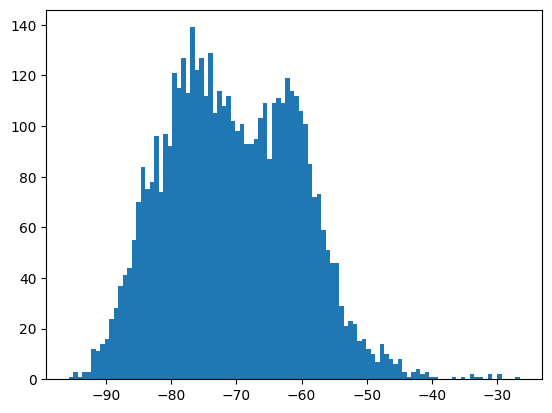

In [102]:
""" Okay, and now we calculate the stress of the belief vectors """

correlation_matrix_noDiag = correlation_matrix_partial - np.eye(correlation_matrix_partial.shape[0])
counts = []
counts = [stress(belief_vectors[i,:], correlation_matrix_partial) for i in range(belief_vectors.shape[0])]

print(counts)

import matplotlib.pyplot as plt
plt.hist(counts, bins=100)
plt.show()